<a href="https://colab.research.google.com/github/vestinabert/Image_Processing/blob/main/Image_Quality_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
path = kagglehub.dataset_download("maindolaamit/tid2013")

# Print dataset path
print("Path to dataset files:", path)

# Check files in dataset directory
print("Files in dataset directory:", os.listdir(path))


Path to dataset files: /root/.cache/kagglehub/datasets/maindolaamit/tid2013/versions/1
Files in dataset directory: ['tid2013']


In [21]:
reference_images_path = os.path.join(tid2013_path, 'reference_images')


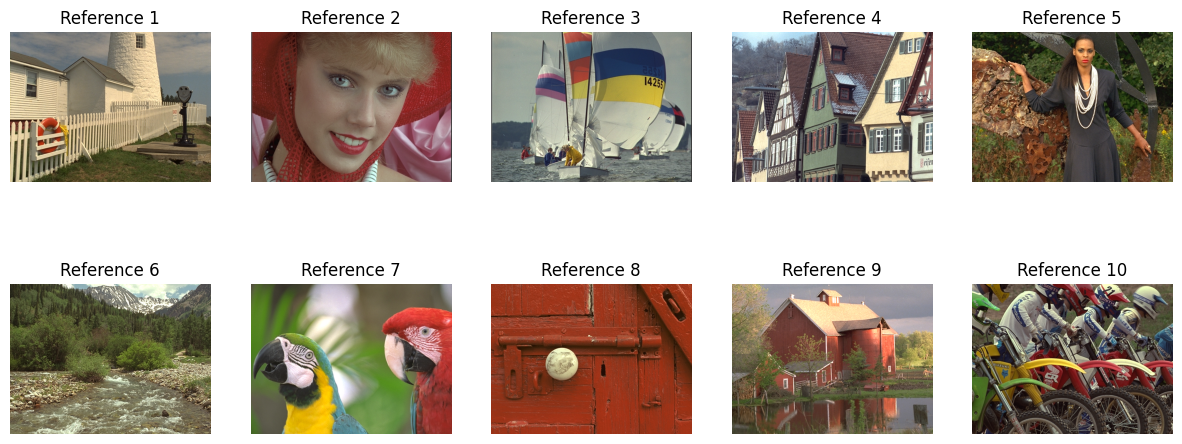

In [22]:
# Get reference image filenames
reference_image_files = [f for f in os.listdir(reference_images_path) if f.endswith('.BMP')]

# Choose number of reference images to display
num_images = min(len(reference_image_files), 10)  # Show max 10 images

# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flatten()):
    ref_img_path = os.path.join(reference_images_path, reference_image_files[i])
    ref_img = mpimg.imread(ref_img_path)  # Read reference image
    ax.imshow(ref_img)
    ax.axis('off')  # Hide axes
    ax.set_title(f"Reference {i+1}")

plt.show()


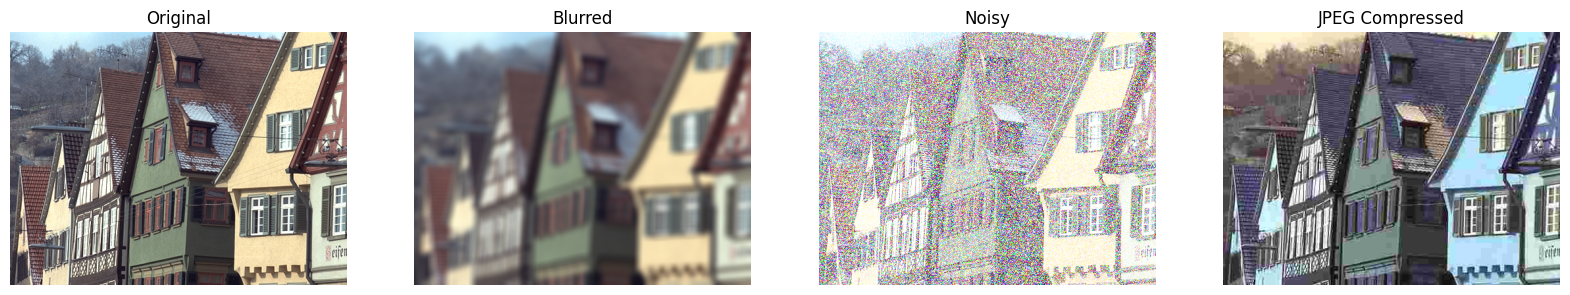

In [24]:
# Select a random reference image
random_ref_image = random.choice(reference_image_files)
reference_img_path = os.path.join(reference_images_path, random_ref_image)

# Read the reference image
reference_img = cv2.imread(reference_img_path)
reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply Blur
blurred_img = cv2.GaussianBlur(reference_img, (15, 15), 5)

# Add Noise
noise = np.random.normal(0, 25, reference_img.shape).astype(np.uint8)
noisy_img = cv2.add(reference_img, noise)

# Apply JPEG Compression
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 10]  # Low quality JPEG
_, compressed_img = cv2.imencode('.jpg', reference_img, encode_param)
compressed_img = cv2.imdecode(compressed_img, cv2.IMREAD_COLOR)
compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Image titles
titles = ["Original", "Blurred", "Noisy", "JPEG Compressed"]
images = [reference_img, blurred_img, noisy_img, compressed_img]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.show()


Blur sumažina ryškumą, išlygindamas kraštus ir tekstūras.  
Triukšmas prideda grūdėtus, atsitiktinius svyravimus, kurie blogina kokybę.  
JPEG suspaudimas sumažina failo dydį, tačiau sukuria matomus suspaudimo artefaktus.

In [25]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Compute PSNR & SSIM for each distortion
psnr_blur = psnr(reference_img, blurred_img)
ssim_blur = ssim(reference_img, blurred_img, channel_axis=2)

psnr_noise = psnr(reference_img, noisy_img)
ssim_noise = ssim(reference_img, noisy_img, channel_axis=2)

psnr_jpeg = psnr(reference_img, compressed_img)
ssim_jpeg = ssim(reference_img, compressed_img, channel_axis=2)

# Print results
print(f"📉 Blur - PSNR: {psnr_blur:.2f} dB, SSIM: {ssim_blur:.3f}")
print(f"📉 Noise - PSNR: {psnr_noise:.2f} dB, SSIM: {ssim_noise:.3f}")
print(f"📉 JPEG - PSNR: {psnr_jpeg:.2f} dB, SSIM: {ssim_jpeg:.3f}")


📉 Blur - PSNR: 17.62 dB, SSIM: 0.339
📉 Noise - PSNR: 7.73 dB, SSIM: 0.206
📉 JPEG - PSNR: 19.09 dB, SSIM: 0.736


Aukštesnis PSNR reiškia geresnę kokybę ir mažesnę iškraipymą.  
Aukštesnis SSIM rodo didesnį struktūrinį panašumą ir artimesnį atitikimą originalui.  
Neryškumas dažniausiai turi aukštą PSNR, bet žemesnį SSIM, nes prarandami kraštai.  
Triukšmas sumažina tiek PSNR, tiek SSIM.  
JPEG suspaudimas sukuria matomus blokų artefaktus, kurie mažina SSIM.

In [29]:
import brisque
from skimage.restoration import estimate_sigma
from skimage import img_as_float

# BRISQUE calculator
brisque_calculator = brisque.BRISQUE()

# Function to compute NIQE (approximated using noise level)
def calculate_niqe(image):
    """ Compute NIQE using estimated noise level """
    image = img_as_float(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    sigma = estimate_sigma(image, channel_axis=None, average_sigmas=True)
    return sigma * 10  # Scaling factor for visualization

# Compute BRISQUE scores
brisque_blur = brisque_calculator.score(blurred_img)
brisque_noise = brisque_calculator.score(noisy_img)
brisque_jpeg = brisque_calculator.score(compressed_img)

# Compute NIQE scores
niqe_blur = calculate_niqe(blurred_img)
niqe_noise = calculate_niqe(noisy_img)
niqe_jpeg = calculate_niqe(compressed_img)

# Print results
print(f"📊 Blur - BRISQUE: {brisque_blur:.2f}, NIQE: {niqe_blur:.2f}")
print(f"📊 Noise - BRISQUE: {brisque_noise:.2f}, NIQE: {niqe_noise:.2f}")
print(f"📊 JPEG - BRISQUE: {brisque_jpeg:.2f}, NIQE: {niqe_jpeg:.2f}")


📊 Blur - BRISQUE: 76.13, NIQE: 0.01
📊 Noise - BRISQUE: 155.84, NIQE: 1.41
📊 JPEG - BRISQUE: 50.83, NIQE: 0.02


Mažesnis BRISQUE balas reiškia geresnę kokybę.  
Mažesnis NIQE balas reiškia, kad vaizdas artimesnis aukštos kokybės natūraliam vaizdui.  
Neryškūs vaizdai dažniausiai turi aukštesnius BRISQUE ir NIQE balus, nes nukrypsta nuo natūralių tekstūrų.  
Triukšmingi vaizdai paprastai turi aukštą BRISQUE, bet žemesnį NIQE, nes triukšmas sukuria nenatūralius aukšto dažnio komponentus.  
JPEG suspausti vaizdai dažnai turi aukštus BRISQUE ir NIQE balus dėl blokų artefaktų.

In [32]:
import mahotas as mt
import numpy as np

def compute_haralick_features(image):
    """
    Computes Haralick texture features from a grayscale image.

    Parameters:
    - image: Input image (RGB format)

    Returns:
    - Haralick features (mean values of 13 texture descriptors)
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    features = mt.features.haralick(gray).mean(axis=0)  # Compute Haralick features (mean across angles)
    return features

# Compute Haralick features for each distorted image
haralick_blur = compute_haralick_features(blurred_img)
haralick_noise = compute_haralick_features(noisy_img)
haralick_jpeg = compute_haralick_features(compressed_img)

# Print results (only first 5 features for readability)
print(f"📊 Blur - Haralick Features: {haralick_blur[:5]}")
print(f"📊 Noise - Haralick Features: {haralick_noise[:5]}")
print(f"📊 JPEG - Haralick Features: {haralick_jpeg[:5]}")


📊 Blur - Haralick Features: [9.66936764e-04 1.91202711e+01 9.96423417e-01 2.67303022e+03
 4.06636837e-01]
📊 Noise - Haralick Features: [1.91850636e-03 4.27306915e+03 3.01868848e-01 3.06035927e+03
 7.33232264e-02]
📊 JPEG - Haralick Features: [3.20864037e-03 8.89604549e+02 8.88106683e-01 3.97494418e+03
 2.95681536e-01]


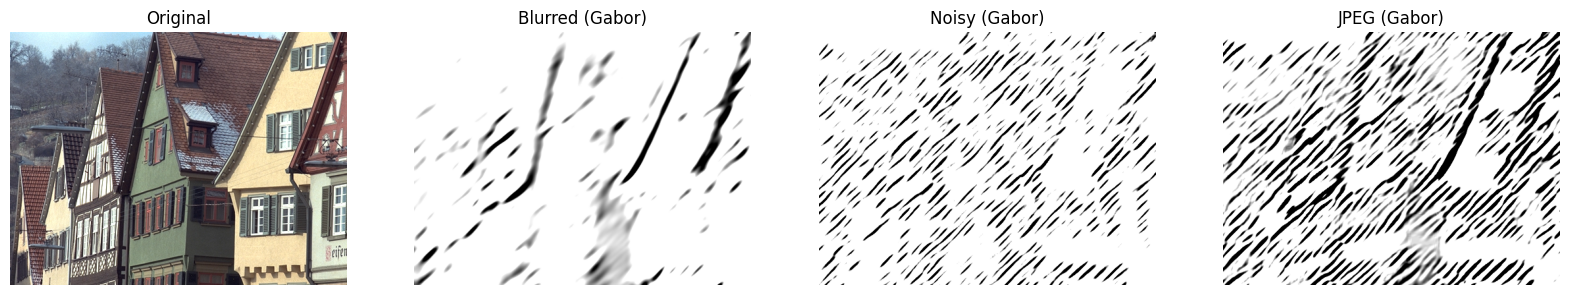

In [33]:
def apply_gabor_filter(image, ksize=31, sigma=5, theta=np.pi/4, lambd=10.0, gamma=0.5):
    """
    Applies a Gabor filter to an image to detect texture patterns.

    Parameters:
    - image: Input image (RGB format)
    - ksize: Kernel size
    - sigma: Standard deviation of the Gaussian function
    - theta: Orientation of the filter
    - lambd: Wavelength of sinusoidal component
    - gamma: Spatial aspect ratio

    Returns:
    - Filtered image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    filtered_image = cv2.filter2D(gray, cv2.CV_8UC3, gabor_kernel)  # Apply filter
    return filtered_image

# Apply Gabor filter to distorted images
gabor_blur = apply_gabor_filter(blurred_img)
gabor_noise = apply_gabor_filter(noisy_img)
gabor_jpeg = apply_gabor_filter(compressed_img)

# Display Gabor filter results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ["Original", "Blurred (Gabor)", "Noisy (Gabor)", "JPEG (Gabor)"]
images = [reference_img, gabor_blur, gabor_noise, gabor_jpeg]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.show()


Haralick features: Describe texture properties such as contrast, homogeneity, and entropy.
Gabor filters: Highlight edge patterns and oriented textures in an image.
Blurred images have smoother textures, so Gabor features appear weaker.
Noisy images show stronger random textures.
JPEG-compressed images may display blocky textures.

In [34]:
import cv2

def compute_laplacian_variance(image):
    """
    Computes the Laplacian variance to measure image sharpness.

    Parameters:
    - image: Input image (RGB format)

    Returns:
    - Laplacian variance (higher = sharper image)
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # Compute variance
    return laplacian_var

# Compute Laplacian variance for each distorted image
laplacian_blur = compute_laplacian_variance(blurred_img)
laplacian_noise = compute_laplacian_variance(noisy_img)
laplacian_jpeg = compute_laplacian_variance(compressed_img)

# Print results
print(f"📏 Blur - Laplacian Variance: {laplacian_blur:.2f}")
print(f"📏 Noise - Laplacian Variance: {laplacian_noise:.2f}")
print(f"📏 JPEG - Laplacian Variance: {laplacian_jpeg:.2f}")


📏 Blur - Laplacian Variance: 4.08
📏 Noise - Laplacian Variance: 41198.12
📏 JPEG - Laplacian Variance: 2788.98


In [35]:
def is_blurry(image, threshold=100):
    """
    Detects if an image is blurry using the Laplacian variance method.

    Parameters:
    - image: Input image (RGB format)
    - threshold: Blur threshold (default = 100)

    Returns:
    - Boolean: True if image is blurry, False if sharp
    """
    laplacian_var = compute_laplacian_variance(image)  # Compute sharpness
    return laplacian_var, laplacian_var < threshold  # Return variance & blur status

# Check if images are blurry
laplacian_blur, is_blurry_blur = is_blurry(blurred_img)
laplacian_noise, is_blurry_noise = is_blurry(noisy_img)
laplacian_jpeg, is_blurry_jpeg = is_blurry(compressed_img)

# Print results
print(f"📏 Blur - Laplacian: {laplacian_blur:.2f}, Blurry: {is_blurry_blur}")
print(f"📏 Noise - Laplacian: {laplacian_noise:.2f}, Blurry: {is_blurry_noise}")
print(f"📏 JPEG - Laplacian: {laplacian_jpeg:.2f}, Blurry: {is_blurry_jpeg}")


📏 Blur - Laplacian: 4.08, Blurry: True
📏 Noise - Laplacian: 41198.12, Blurry: False
📏 JPEG - Laplacian: 2788.98, Blurry: False


Jei dispersija < 100, vaizdas yra neryškus.  
Jei dispersija > 100, vaizdas yra ryškus.  
Neryškūs vaizdai turės labai mažą dispersiją.  
Triukšmingi vaizdai gali turėti didelę dispersiją dėl triukšmo kraštų.  
JPEG suspausti vaizdai gali turėti vidutinę dispersiją priklausomai nuo kokybės.

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_histograms(image):
    """
    Computes histograms for RGB, HSV, and LAB color spaces.

    Parameters:
    - image: Input image (RGB format)

    Returns:
    - Dictionary containing histograms for each color space
    """
    # Convert image to different color spaces
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab_img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    histograms = {
        "RGB": [cv2.calcHist([image], [i], None, [256], [0, 256]) for i in range(3)],
        "HSV": [cv2.calcHist([hsv_img], [i], None, [256], [0, 256]) for i in range(3)],
        "LAB": [cv2.calcHist([lab_img], [i], None, [256], [0, 256]) for i in range(3)]
    }

    return histograms



In [43]:
# Compute histograms
hist_blur = compute_histograms(blurred_img)
hist_noise = compute_histograms(noisy_img)
hist_jpeg = compute_histograms(compressed_img)

In [44]:
def plot_histograms(histograms, title):
    """
    Plots RGB, HSV, and LAB histograms.

    Parameters:
    - histograms: Dictionary containing histograms for each color space
    - title: Title for the plot
    """
    color_spaces = ["RGB", "HSV", "LAB"]
    colors = [["red", "green", "blue"], ["orange", "purple", "pink"], ["black", "gray", "brown"]]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows, 3 columns

    for row, (space, color_labels) in enumerate(zip(color_spaces, colors)):
        for col in range(3):
            axes[row, col].plot(histograms[space][col], color=color_labels[col])
            axes[row, col].set_title(f"{space} - {color_labels[col].capitalize()}")
            axes[row, col].set_xlim([0, 256])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



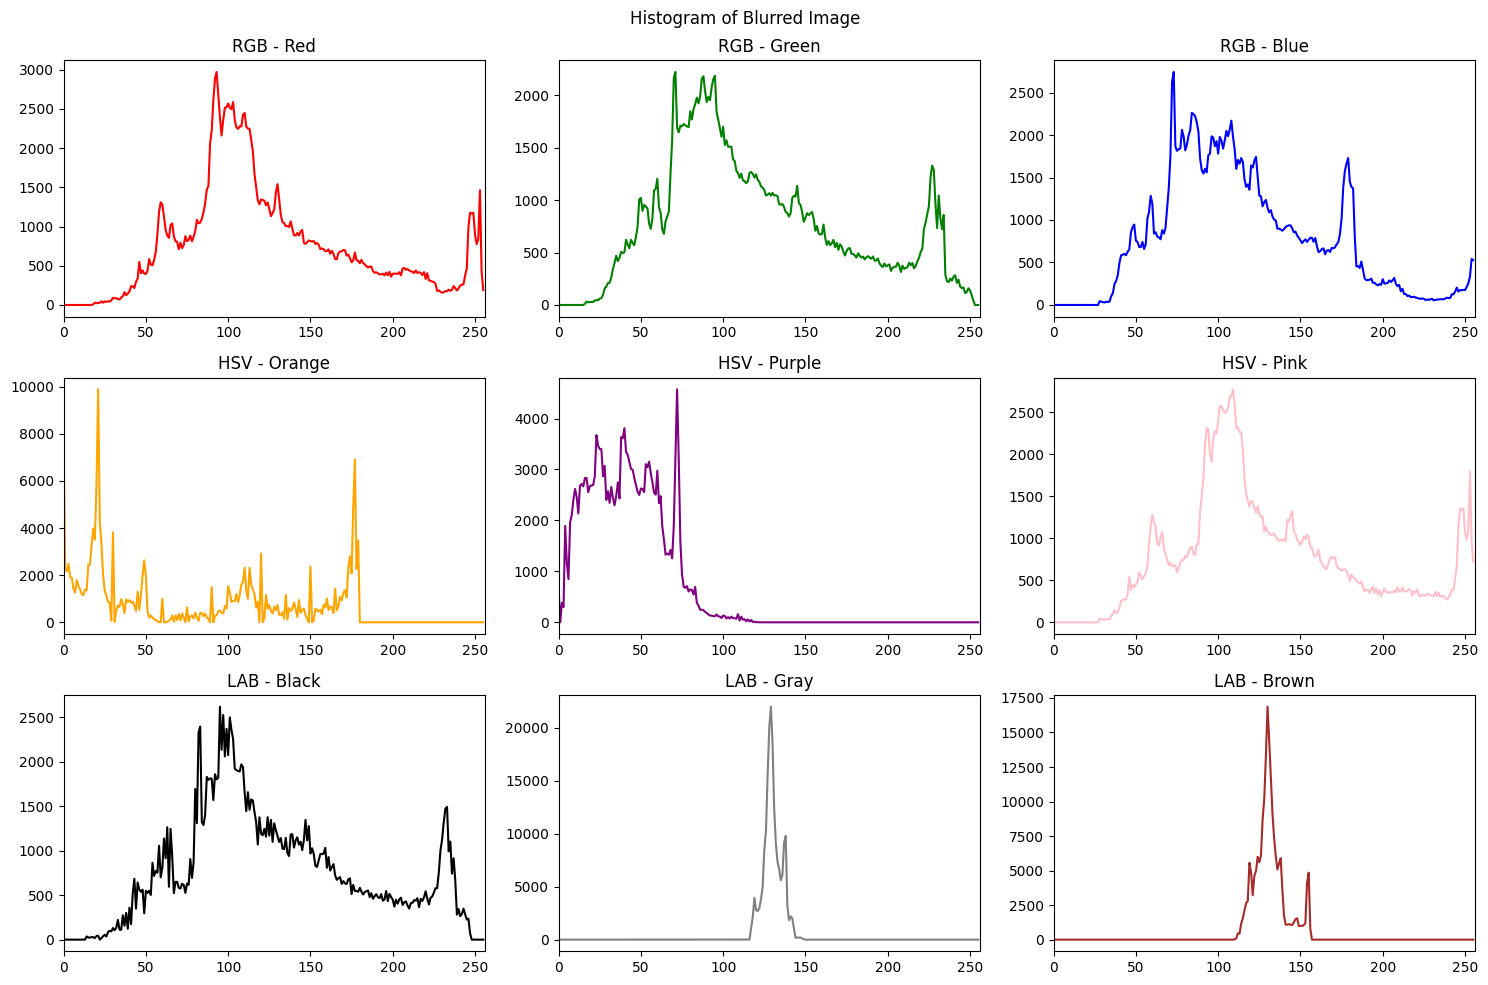

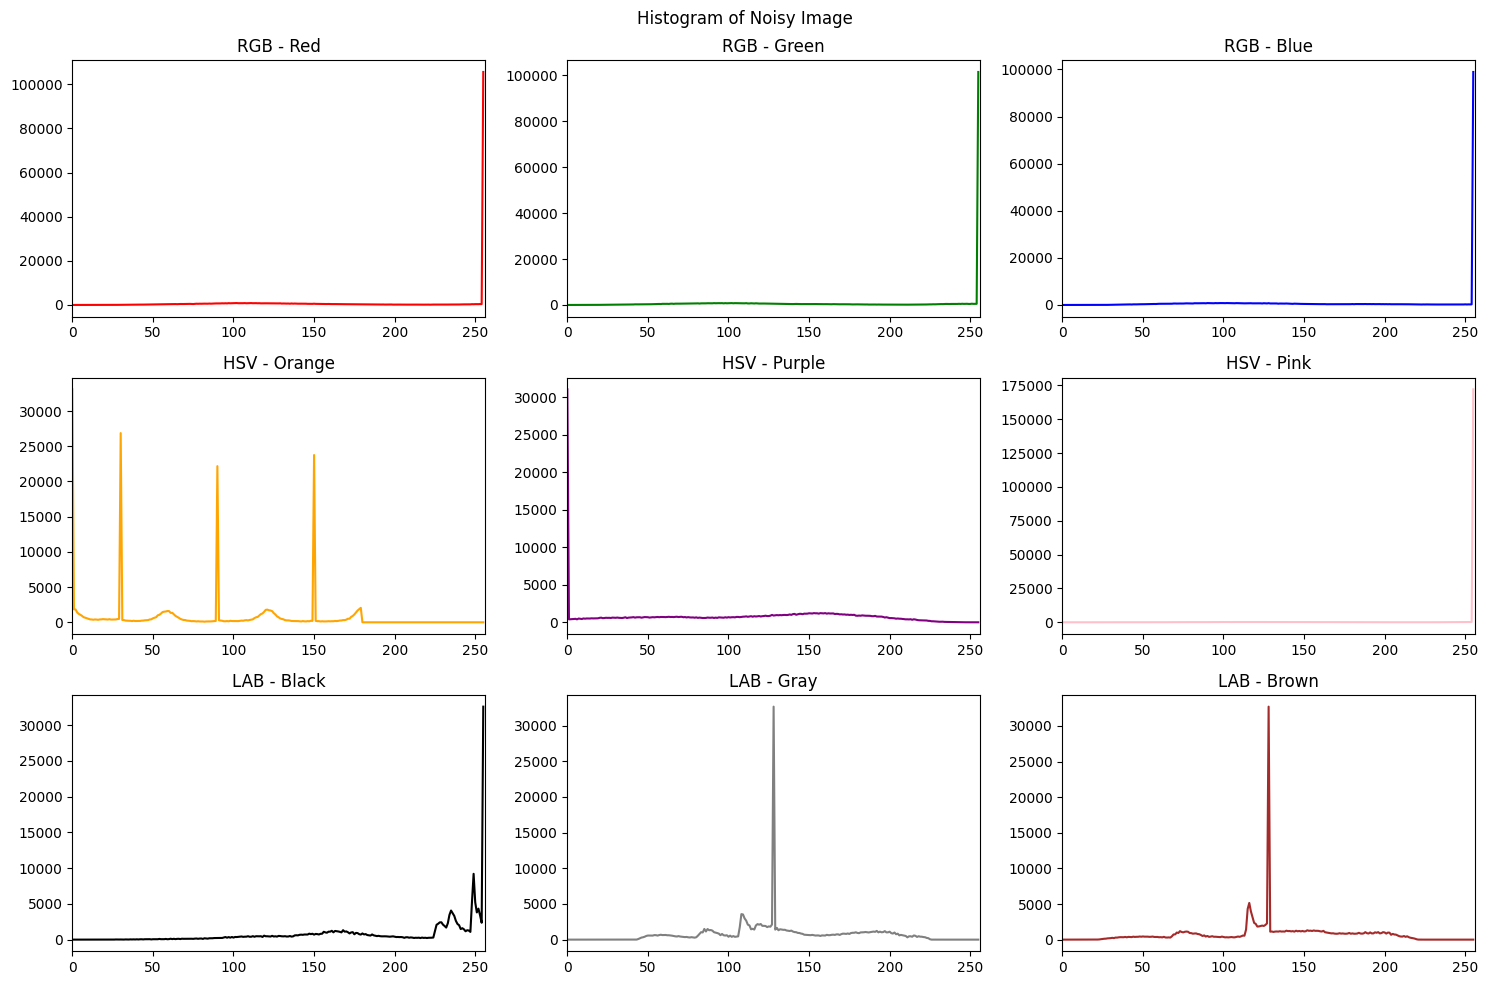

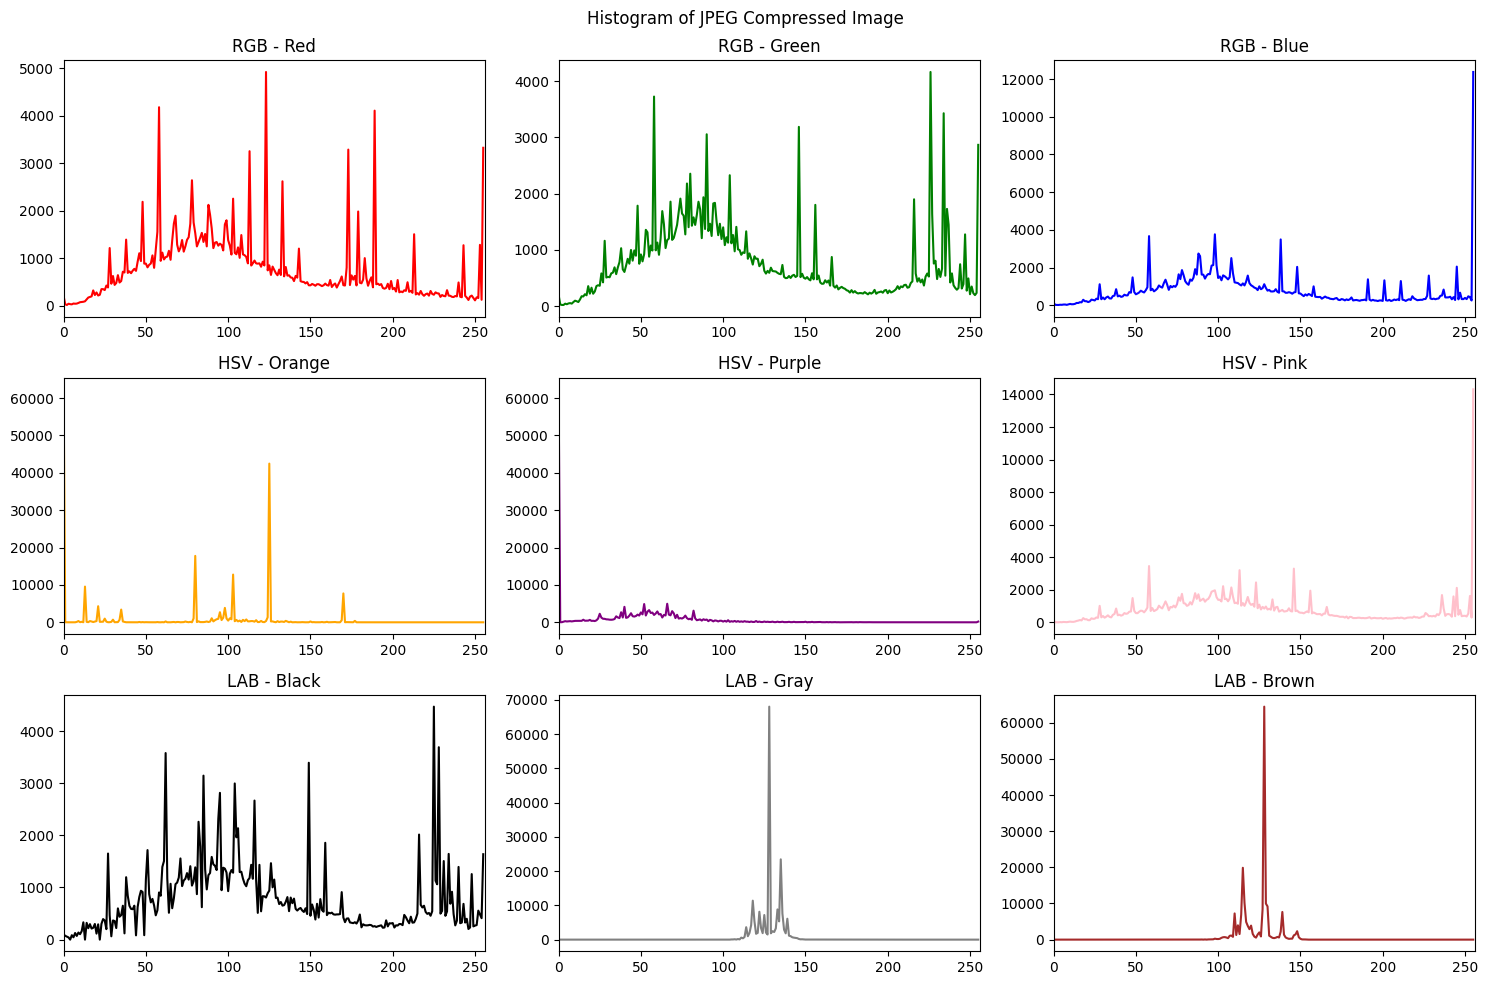

In [45]:
# Plot histograms for different distortions
plot_histograms(hist_blur, "Histogram of Blurred Image")
plot_histograms(hist_noise, "Histogram of Noisy Image")
plot_histograms(hist_jpeg, "Histogram of JPEG Compressed Image")


Neryškūs vaizdai histogramose gali rodyti sumažėjusį kontrastą.  
Triukšmingi vaizdai gali turėti išsklaidytas histogramas dėl atsitiktinių pikselių variacijų.  
JPEG suspausti vaizdai gali rodyti spalvų poslinkius dėl suspaudimo artefaktų.

In [62]:
import numpy as np

def compute_michelson_contrast(image, epsilon=1e-6):
    """
    Computes Michelson contrast for a grayscale image with overflow protection.

    Parameters:
    - image: Input image (RGB format)
    - epsilon: Small constant to prevent division overflow

    Returns:
    - Michelson contrast value
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float64)  # Convert to grayscale with float64
    I_max = np.max(gray)  # Maximum intensity
    I_min = np.min(gray)  # Minimum intensity

    # Prevent overflow by ensuring denominator is valid
    denominator = I_max + I_min
    if np.isinf(denominator) or denominator < epsilon:  # Avoid division by zero or infinity
        return 0.0  # Return zero contrast if invalid

    contrast = (I_max - I_min) / denominator
    return contrast



def compute_weber_contrast(image):
    """
    Computes Weber contrast for a grayscale image.

    Parameters:
    - image: Input image (RGB format)

    Returns:
    - Weber contrast value
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    I_max = np.max(gray)
    I_background = np.mean(gray)  # Using mean intensity as background
    contrast = (I_max - I_background) / I_background
    return contrast

# Compute contrast for each distorted image
michelson_blur = compute_michelson_contrast(blurred_img)
weber_blur = compute_weber_contrast(blurred_img)

michelson_noise = compute_michelson_contrast(noisy_img)
weber_noise = compute_weber_contrast(noisy_img)

michelson_jpeg = compute_michelson_contrast(compressed_img)
weber_jpeg = compute_weber_contrast(compressed_img)

# Print results
print(f"🔳 Blur - Michelson: {michelson_blur:.4f}, Weber: {weber_blur:.4f}")
print(f"🔳 Noise - Michelson: {michelson_noise:.4f}, Weber: {weber_noise:.4f}")
print(f"🔳 JPEG - Michelson: {michelson_jpeg:.4f}, Weber: {weber_jpeg:.4f}")


🔳 Blur - Michelson: 0.8626, Weber: 1.0080
🔳 Noise - Michelson: 0.9101, Weber: 0.3079
🔳 JPEG - Michelson: 1.0000, Weber: 1.1378


In [63]:
def apply_clahe(image):
    """
    Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance image contrast.

    Parameters:
    - image: Input image (RGB format)

    Returns:
    - Contrast-enhanced image
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)  # Split LAB channels

    # Apply CLAHE to the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)

    # Merge back LAB channels
    enhanced_lab = cv2.merge((l_clahe, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)  # Convert back to RGB

    return enhanced_rgb


In [64]:
# Apply CLAHE
clahe_blur = apply_clahe(blurred_img)
clahe_noise = apply_clahe(noisy_img)
clahe_jpeg = apply_clahe(compressed_img)


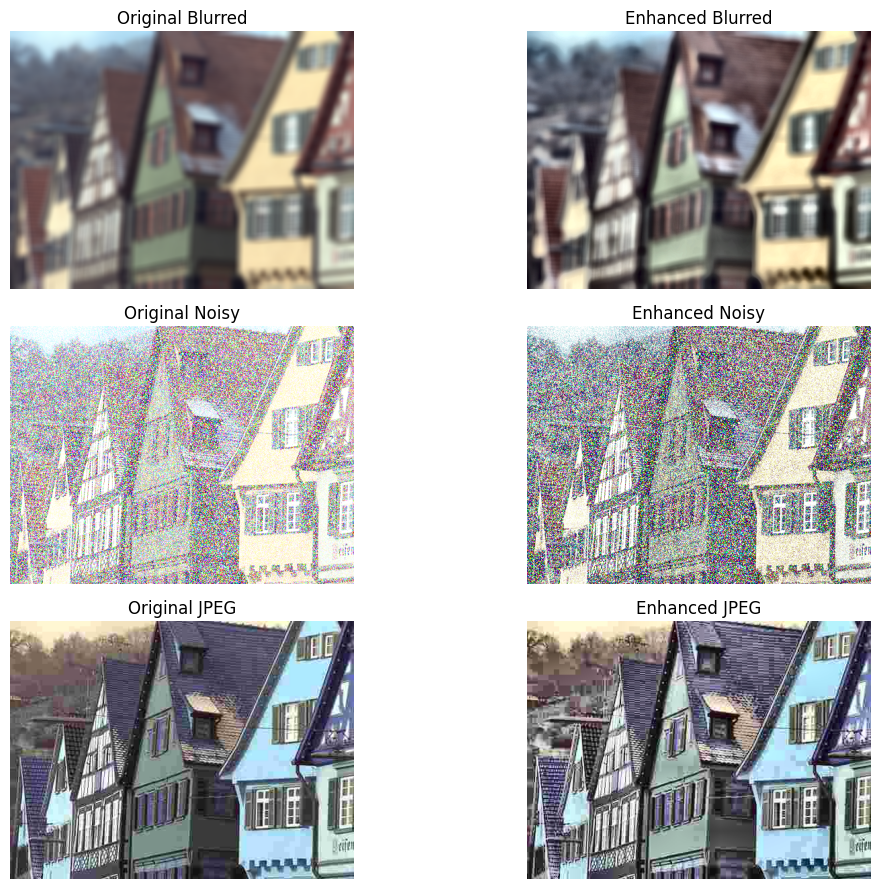

In [65]:
# Display original vs CLAHE-enhanced images
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

titles = ["Original Blurred", "Enhanced Blurred",
          "Original Noisy", "Enhanced Noisy",
          "Original JPEG", "Enhanced JPEG"]

images = [blurred_img, clahe_blur, noisy_img, clahe_noise, compressed_img, clahe_jpeg]

for ax, img, title in zip(axes.flatten(), images, titles):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Extract features for each image
def extract_features(image):
    """ Extracts a set of quality assessment features from an image. """
    brisque_score = brisque_calculator.score(image)
    niqe_score = calculate_niqe(image)
    haralick_features = compute_haralick_features(image)
    laplacian_var = compute_laplacian_variance(image)
    michelson_contrast = compute_michelson_contrast(image)
    weber_contrast = compute_weber_contrast(image)

    # Return feature vector
    return [
        brisque_score, niqe_score, laplacian_var, michelson_contrast, weber_contrast,
        *haralick_features  # Include all Haralick texture features
    ]

# Create dataset with different distortions
data = []
labels = []  # We will use BRISQUE score as the ground truth label

for img, label in zip([blurred_img, noisy_img, compressed_img], ["Blur", "Noise", "JPEG"]):
    features = extract_features(img)
    data.append(features)
    labels.append(brisque_calculator.score(img))  # Use BRISQUE score as a quality label

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    "BRISQUE", "NIQE", "Laplacian", "Michelson", "Weber",
    "Haralick_1", "Haralick_2", "Haralick_3", "Haralick_4", "Haralick_5",
    "Haralick_6", "Haralick_7", "Haralick_8", "Haralick_9", "Haralick_10",
    "Haralick_11", "Haralick_12", "Haralick_13"
])

df["Quality_Score"] = labels  # Target variable

display(df.head())

BRISQUE      NIQE     Laplacian  Michelson     Weber  Haralick_1  \
0   76.132141  0.010901      4.078542   0.862595  1.008030    0.000967   
1  155.845000  1.414808  41198.116248   0.910112  0.307916    0.001919   
2   50.833206  0.015248   2788.983006   1.000000  1.137821    0.003209   

    Haralick_2  Haralick_3   Haralick_4  Haralick_5  Haralick_6    Haralick_7  \
0    19.120271    0.996423  2673.030218    0.406637  242.936397  10673.000602   
1  4273.069153    0.301869  3060.359268    0.073323  389.899402   7968.367917   
2   889.604549    0.888107  3974.944178    0.295682  238.457669  15010.172162   

   Haralick_8  Haralick_9  Haralick_10  Haralick_11  Haralick_12  Haralick_13  \
0    8.461214   11.150815     0.000636     3.123792    -0.508475     0.999694   
1    8.157250   13.500200     0.000029     6.977013    -0.039421     0.646794   
2    8.304087   12.658872     0.000321     5.137948    -0.300420     0.992448   

   Quality_Score  
0      76.132141  
1     155.845000  
2      50.833206

In [67]:
from sklearn.preprocessing import StandardScaler

# Extract only feature columns for clustering
X_features = df.drop(columns=["Quality_Score"])  # Remove the quality score (BRISQUE used as label before)

# Normalize features to bring all values to the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)  # Standardized dataset for clustering


In [68]:
from sklearn.cluster import KMeans

# Apply K-Means with 3 clusters (low, medium, high quality)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

# Show first few results
display(df[["KMeans_Cluster"]].head())


KMeans_Cluster
0               2
1               0
2               1

In [69]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)  # Adjust parameters if needed
df["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled)

# Show first few results
display(df[["DBSCAN_Cluster"]].head())


DBSCAN_Cluster
0              -1
1              -1
2              -1

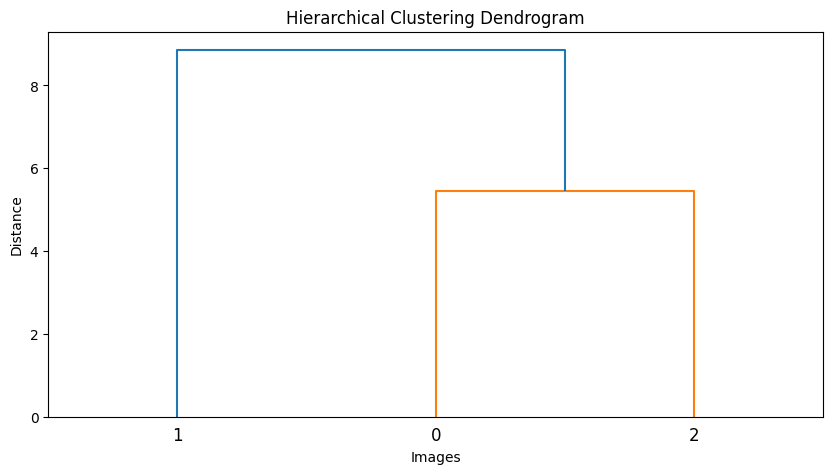

Hierarchical_Cluster
0                     1
1                     1
2                     1

In [70]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

# Compute hierarchical clustering
Z = linkage(X_scaled, method="ward")  # Ward's method minimizes variance
df["Hierarchical_Cluster"] = fcluster(Z, 3, criterion="maxclust")  # Set to 3 clusters

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Images")
plt.ylabel("Distance")
plt.show()

# Show first few results
display(df[["Hierarchical_Cluster"]].head())


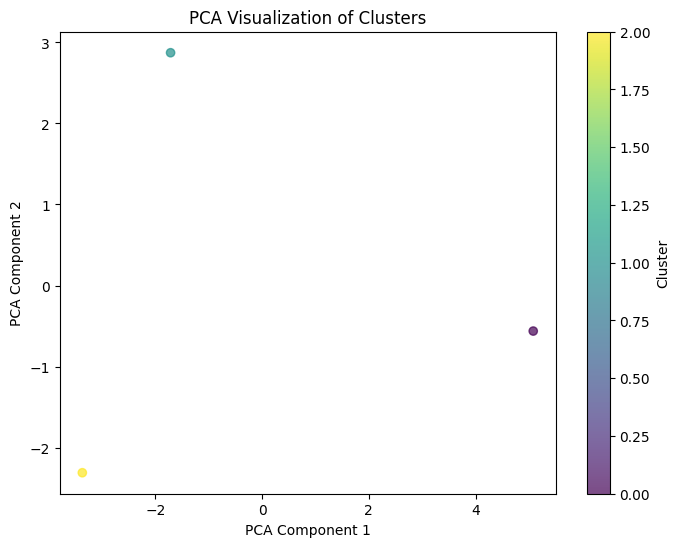

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["KMeans_Cluster"], cmap="viridis", alpha=0.7)
plt.title("PCA Visualization of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


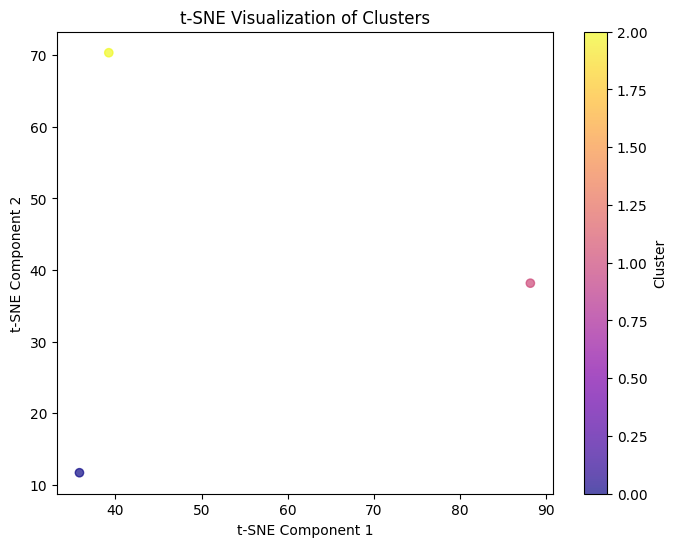

In [73]:
from sklearn.manifold import TSNE

# Ensure perplexity is not larger than dataset size
perplexity_value = min(5, len(X_scaled) - 1)  # Must be less than number of samples

# Apply t-SNE with updated perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE clusters
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["KMeans_Cluster"], cmap="plasma", alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.show()


PCA vizualizacija padeda nustatyti, ar klasteriai yra aiškiai atskirti.  
t-SNE vizualizacija parodo vietinius panašumus tarp vaizdų klasteriuose.  
K-Means klasteriai suskirsto vaizdus į tris kokybės lygius: žemą, vidutinį ir aukštą.  
DBSCAN klasteriai aptinka anomalijas, kai kurie vaizdai gali būti išskirtys.  
Hierarchiniai klasteriai rodo, kaip vaizdai jungiasi į didesnius klasterius.

In [75]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array

# Load VGG16 without the top layer (fully connected layers)
base_model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load ResNet50 without the top layer
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [76]:
import cv2
import numpy as np

def preprocess_image(image):
    """ Resize image to (224,224) and normalize it. """
    image = cv2.resize(image, (224, 224))  # Resize to 224x224
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Preprocess distorted images
X_images = np.array([preprocess_image(img) for img in [blurred_img, noisy_img, compressed_img]])
y_labels = np.array(labels)  # Quality scores (e.g., BRISQUE scores)


In [77]:
# Extract features using VGG16
features_vgg = base_model_vgg.predict(X_images)
features_vgg = features_vgg.reshape(features_vgg.shape[0], -1)  # Flatten features

# Extract features using ResNet50
features_resnet = base_model_resnet.predict(X_images)
features_resnet = features_resnet.reshape(features_resnet.shape[0], -1)  # Flatten features

# Combine features from both models
X_deep_features = np.concatenate((features_vgg, features_resnet), axis=1)

# Show feature shape
print("Feature shape:", X_deep_features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Feature shape: (3, 125440)


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation

# Define a simple DNN model
model = Sequential([
    Dense(512, input_shape=(X_deep_features.shape[1],)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(256, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="linear")  # Regression output (predict quality score)
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
model.fit(X_deep_features, y_labels, epochs=20, batch_size=8, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 14870.3926 - mae: 115.0371 - val_loss: 1931.7196 - val_mae: 43.9513
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 15003.9609 - mae: 115.3370 - val_loss: 997.3210 - val_mae: 31.5804
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 14834.0293 - mae: 115.0843 - val_loss: 330.6875 - val_mae: 18.1848
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14529.1924 - mae: 113.0901 - val_loss: 8.6403 - val_mae: 2.9394
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14142.3965 - mae: 111.7321 - val_loss: 202.8984 - val_mae: 14.2442
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14398.4902 - mae: 113.2344 - val_loss: 966.9655 - val_mae: 31.0961
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14139.4902 - mae: 111.2941 - val_loss: 2291.2529 - val_mae: 47.8670
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 13423.1191 - mae: 108.1418 - val_loss: 4034.7375 - val_mae: 63.5196
Epoch 9/20
1/1 ━━━━━━━━━

In [79]:
# Predict quality scores
predictions = model.predict(X_deep_features)

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_labels, predictions)
mae = mean_absolute_error(y_labels, predictions)

print(f"📊 Model Performance - MSE: {mse:.4f}, MAE: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
📊 Model Performance - MSE: 25288.8136, MAE: 148.0926


In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
import cv2

# Prepare input (distorted) and target (reference) images
X_train = np.array([preprocess_image(img) for img in [blurred_img, noisy_img, compressed_img]])
y_train = np.array([preprocess_image(reference_img)])  # The original high-quality image

# Expand dataset to match dimensions
X_train = np.repeat(X_train, len(y_train), axis=0)
y_train = np.tile(y_train, (len(X_train), 1, 1, 1))

# Show dataset shape
print("Input shape:", X_train.shape)
print("Target shape:", y_train.shape)


Input shape: (3, 224, 224, 3)
Target shape: (3, 224, 224, 3)


In [92]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Load VGG16 once and freeze it
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
loss_model.trainable = False  # Freeze VGG16 to avoid retraining

def perceptual_loss(y_true, y_pred):
    """
    Perceptual loss using preloaded VGG16 feature extraction.
    Encourages visually similar reconstructions.
    """
    return tf.keras.losses.MeanSquaredError()(loss_model(y_true), loss_model(y_pred))

# Define Autoencoder with fixed Skip Connections
input_img = Input(shape=(224, 224, 3))

# Encoder
e1 = Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
e1_p = MaxPooling2D((2, 2), padding="same")(e1)

e2 = Conv2D(128, (3, 3), activation="relu", padding="same")(e1_p)
e2_p = MaxPooling2D((2, 2), padding="same")(e2)

e3 = Conv2D(256, (3, 3), activation="relu", padding="same")(e2_p)
e3_p = MaxPooling2D((2, 2), padding="same")(e3)

# Bottleneck
b = Conv2D(512, (3, 3), activation="relu", padding="same")(e3_p)

# Decoder
d3 = UpSampling2D((2, 2))(b)
d3 = Conv2D(256, (3, 3), activation="relu", padding="same")(d3)
d3 = concatenate([d3, e3])  # Now dimensions match

d2 = UpSampling2D((2, 2))(d3)
d2 = Conv2D(128, (3, 3), activation="relu", padding="same")(d2)
d2 = concatenate([d2, e2])  # Now dimensions match

d1 = UpSampling2D((2, 2))(d2)
d1 = Conv2D(64, (3, 3), activation="relu", padding="same")(d1)
d1 = concatenate([d1, e1])  # Now dimensions match

# Output layer
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(d1)

# Compile the Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss=perceptual_loss)  # Use fixed perceptual loss

# Show model summary
autoencoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 224, 224, 64)   │          1,792 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 112, 112, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 56, 56, 128)    │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 28, 28, 256)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7           │ (None, 56, 56, 512)    │              0 │ conv2d_23[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 256)    │      1,179,904 │ up_sampling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 56, 56, 512)    │              0 │ conv2d_24[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 112, 112, 512)  │              0 │ concatenate_4[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 112, 112, 128)  │        589,952 │ up_sampling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 112, 112, 256)  │              0 │ conv2d_25[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_9           │ (None, 224, 224, 256)  │              0 │ concatenate_5[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├──────────────────────

 Total params: 3,471,811 (13.24 MB)

 Trainable params: 3,471,811 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
autoencoder.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 81.7390 - val_loss: 68.3025
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 77.5557 - val_loss: 59.9691
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 69.9160 - val_loss: 56.7843
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 66.4922 - val_loss: 55.4899
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 63.4431 - val_loss: 53.6689
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 62.1747 - val_loss: 51.1984
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 60.3219 - val_loss: 49.2963
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 59.6800 - val_loss: 47.1841
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 57.8042 - val_loss: 45.5866
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 56.8064 - val_loss: 44.3553
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 55.7988 - val_loss: 43.0798
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 54.70

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


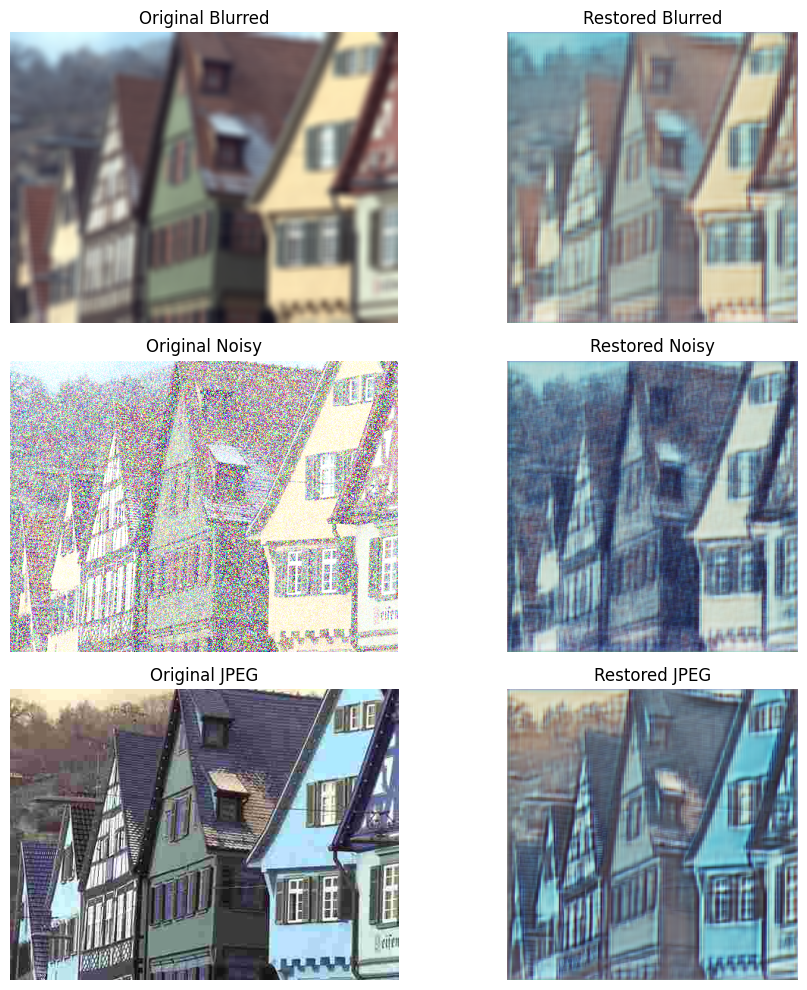

In [94]:
# Get reconstructed images
X_reconstructed = autoencoder.predict(X_train)

# Display original vs restored images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

titles = ["Original Blurred", "Restored Blurred",
          "Original Noisy", "Restored Noisy",
          "Original JPEG", "Restored JPEG"]

images = [blurred_img, X_reconstructed[0], noisy_img, X_reconstructed[1], compressed_img, X_reconstructed[2]]

for ax, img, title in zip(axes.flatten(), images, titles):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [99]:
# Convert reference image to match dtype of restored images
reference_resized = cv2.resize(reference_img, (224, 224)).astype(np.float32) / 255.0

# Compute PSNR & SSIM for Autoencoder Restored Images
for i, label in enumerate(["Blurred", "Noisy", "JPEG"]):
    restored_img = X_reconstructed[i]  # Restored image

    # Ensure both images have the same dtype and shape
    restored_img_resized = cv2.resize(restored_img, (224, 224)).astype(np.float32) / 255.0

    psnr_value = psnr(reference_resized, restored_img_resized, data_range=1.0)
    ssim_value = ssim(reference_resized, restored_img_resized, data_range=1.0, channel_axis=2)

    print(f"📊 {label} - PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.3f}")


📊 Blurred - PSNR: 5.52 dB, SSIM: 0.002
📊 Noisy - PSNR: 5.51 dB, SSIM: 0.002
📊 JPEG - PSNR: 5.51 dB, SSIM: 0.002


Maža PSNR reikšmė reiškia, kad atkurto vaizdo kokybė reikšmingai skiriasi nuo originalo.  
Geros PSNR reikšmės vaizdo atkūrimui turėtų būti didesnės nei 20–30 dB.  
Mažesnė nei 10 dB reikšmė rodo, kad išvesties vaizdas labai skiriasi nuo etaloninio vaizdo.  

SSIM matuoja struktūrinį panašumą (tekstūras, kraštus ir kontrastą).  
Maža SSIM reikšmė (~0,002) reiškia, kad atkurtas vaizdas nėra panašus į originalą.  
Geros SSIM reikšmės, užtikrinančios aukštos kokybės atkūrimą, yra didesnės nei 0,8.